In [146]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
from src.Evaluation.disco import disco_samples, p_noise
from src.utils.metrics import METRICS
import numpy as np
import matplotlib.pyplot as plt

METRICS["DISCO_non_noise"] = lambda X, l: np.mean(disco_samples(X, l)[l!=-1])
METRICS["DISCO_noise"] = lambda X, l: np.mean(disco_samples(X, l)[l==-1])
METRICS["DISCO_core_prop"] = lambda X, l: np.mean(p_noise(X, l)[0])
METRICS["DISCO_dc_prop"] = lambda X, l: np.mean(p_noise(X, l)[1])

for name in METRICS.keys():
    METRICS[name].__name__ = name

METRICS.keys()

dict_keys(['DISCO', 'DBCV', 'DCSI', 'LCCV', 'VIASCKDE', 'CVDD', 'CDBW', 'CVNN', 'SILHOUETTE', 'S_DBW', 'DISCO_non_noise', 'DISCO_noise', 'DISCO_core_prop', 'DISCO_dc_prop'])

In [148]:
from mpire.pool import WorkerPool
import warnings
warnings.filterwarnings("ignore")

def print_scores(X, l):

    def get_score(eval_metric):
        try:
            return f"{eval_metric.__name__}: {round(eval_metric(X, l), 2)}"
        except:
            pass

    # pool = WorkerPool(20, use_dill=True)
    # results = pool.imap(get_score, METRICS.values())
    results = []
    for result in results:
        print(result)

In [162]:
import matplotlib.colors as mcolors
from src.utils.colors import colors

def plot_data(X, l, save_fig=None, save_format="png", show=True, cluster_marker_size=15, noise_marker_size=80):
    fig = plt.figure()
    cmap = mcolors.ListedColormap([colors["purple"], colors["red"], colors["green"], colors["blue"], colors["orange"]])
    plt.scatter(
        X[:, 0][l != -1][::2],
        X[:, 1][l != -1][::2],
        s=cluster_marker_size,
        c=l[l != -1][::2],
        vmin=-1,
        vmax=3,
        cmap=cmap,
    )
    plt.scatter(X[:, 0][l==-1], X[:, 1][l==-1], s=noise_marker_size, c=l[l==-1], vmin=-1, vmax=3, cmap=cmap, marker="1")
    plt.xticks([])
    plt.yticks([])
    if save_fig:
        plt.savefig(f"imgs/motivation/{save_fig}.{save_format}", format=save_format, dpi=300, bbox_inches="tight", pad_inches=0
        )
    if show:
        plt.show()
    return fig

In [150]:
# from datasets.density_datasets import Datasets as DensityDatasets

# X, l = DensityDatasets.dartboard1.standardized_data_cached

n_points per cluster: [100, 200, 300, 400]
(1000, 2) (1000,)


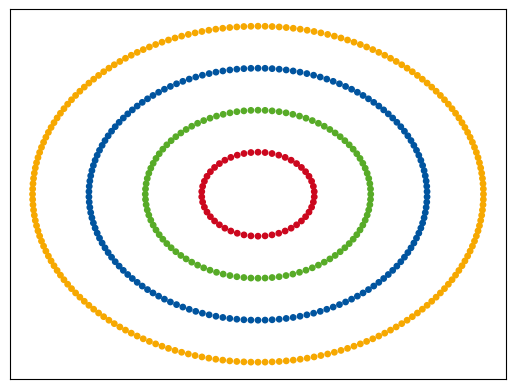

In [151]:
import math

radii = [5,10,15,20]
n_points_per_cluster = [100,200,300,400]

X = np.array(
    [
        [math.sin((2 * math.pi / n_points) * i) * radius, math.cos((2 * math.pi / n_points) * i) * radius]
        for radius, n_points in zip(radii, n_points_per_cluster)
        for i in range(n_points)
    ]
)
l = np.array(sum([[c] * n_points for c, n_points in enumerate(n_points_per_cluster)], []))

print("n_points per cluster:", [len(l[l == i]) for i in set(l)])
print(X.shape, l.shape)

plot_data(X, l, save_fig="dartboard")
print_scores(X, l)

(1000, 2) (1000,)


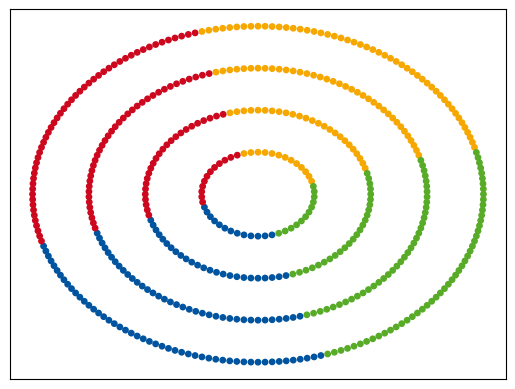

In [152]:
from sklearn.cluster import KMeans
np.random.seed(0)
l_kmeans = KMeans(4).fit_predict(X)

print(X.shape, l_kmeans.shape)

plot_data(X, l_kmeans, save_fig="dartboard_kmeans")
print_scores(X, l_kmeans)

(1300, 2) (1300,)


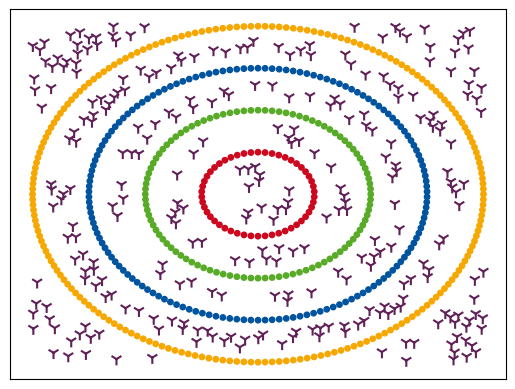

In [153]:
from src.utils.data import add_noise

np.random.seed(0)
X_noise, l_noise = add_noise(X, l, 300, 1.6, 0.6)
# X_noise, l2 = add_noise(X, l1, 70, 0.15, 0.07)

print(X_noise.shape, l_noise.shape)

plot_data(X_noise, l_noise, save_fig="dartboard_noise")
print_scores(X_noise, l_noise)

(1300, 2) (1300,)


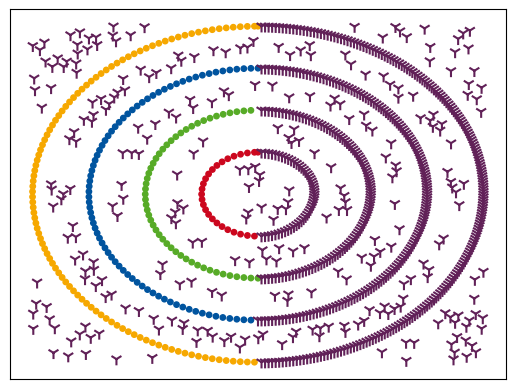

In [169]:
l_right_noise = l_noise.copy()
idx = np.where(X[:, 0] > 0)[0]
l_right_noise[idx] = -1

print(X_noise.shape, l_right_noise.shape)

plot_data(X_noise, l_right_noise, save_fig="dartboard_noise_split")
print_scores(X_noise, l_right_noise)

(1300, 2) (1300,)


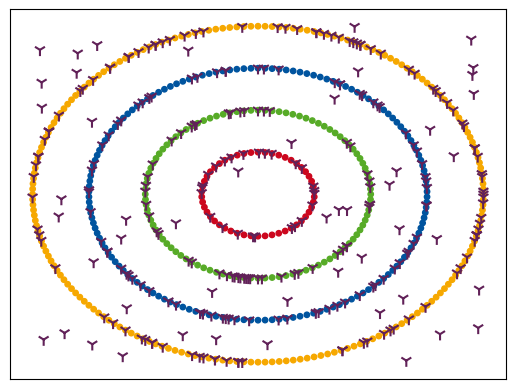

In [155]:
import math
from functools import reduce
np.random.seed(200)

r = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)
radii = np.unique(np.round(r))

n_noise_list = reduce(lambda list, elem: list + [list[-1] + list[0]], range(3), [25])
n_noise = sum(n_noise_list, 0)
l_circle_noise = sum([[i] * n_noise for i, n_noise in enumerate(n_noise_list)], [])

angles = np.random.choice(360, size=n_noise, replace=True).astype(float)
angles *= (2 * math.pi / 360)

X_circle_noise = np.array(
    [[math.sin(angle) * radii[id], math.cos(angle) * radii[id]] for id, angle in zip(l_circle_noise, angles)]
)

X_n_circ = X.copy()
X_n_circ = np.vstack((X_n_circ, X_circle_noise))

l_n_circ = l.copy()
l_n_circ = np.hstack((l_n_circ, np.array([-1] * n_noise)))

from src.utils.data import add_noise
np.random.seed(0)
X_n_circ, l_n_circ = add_noise(X_n_circ, l_n_circ, 50, 1.6, 0.6)

print(X_n_circ.shape, l_n_circ.shape)

plot_data(X_n_circ, l_n_circ, save_fig="dartboard_noise_on_circle")
print_scores(X_n_circ, l_n_circ)

(1300, 2) (1300,)


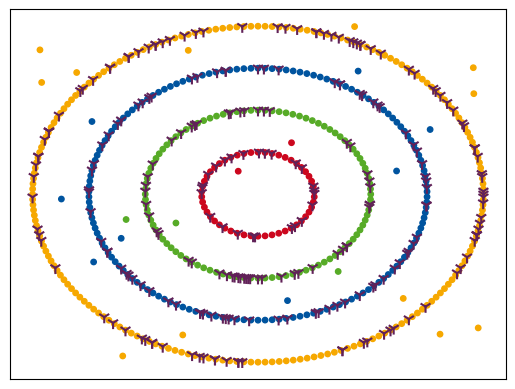

In [156]:
from sklearn.neighbors import NearestNeighbors

noise = X_n_circ[-50:]

nbrs = NearestNeighbors(n_neighbors=1).fit(X)
_, idx = nbrs.kneighbors(noise)
l_n_cirl_nn = l_n_circ.copy()
l_n_cirl_nn[-50:] = l[idx].flatten()

print(X_n_circ.shape, l_n_cirl_nn.shape)

plot_data(X_n_circ, l_n_cirl_nn, save_fig="dartboard_noise_on_circle_nn")
print_scores(X_n_circ, l_n_cirl_nn)

(1300, 2) (1300,)


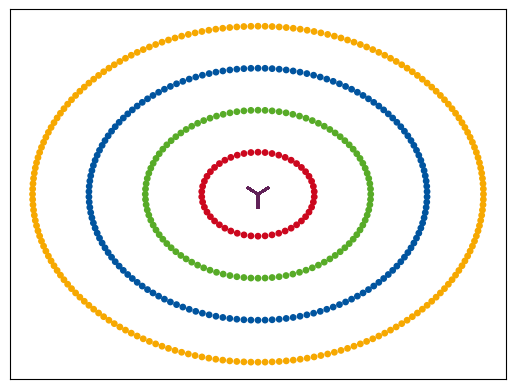

In [157]:
X_noise_c = X_noise.copy()
X_noise_c[-300:] = [0, 0]

print(X_noise_c.shape, l_noise.shape)

plot_data(X_noise_c, l_noise, save_fig="dartboard_noise_center", noise_marker_size=400)
print_scores(X_noise_c, l_noise)

(1300, 2) (1300,)


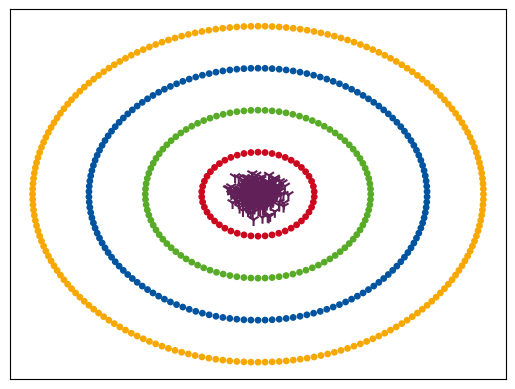

In [158]:
from sklearn.datasets import make_blobs

noise_blob = make_blobs(centers=[[0, 0]], n_samples=300, random_state=0)
noise_blob[0]
X_noise_c = X_noise.copy()
X_noise_c[-300:] = noise_blob[0]

print(X_noise_c.shape, l_noise.shape)

plot_data(X_noise_c, l_noise, save_fig="dartboard_noise_center_blob")
print_scores(X_noise_c, l_noise)

(1300, 2) (1300,)


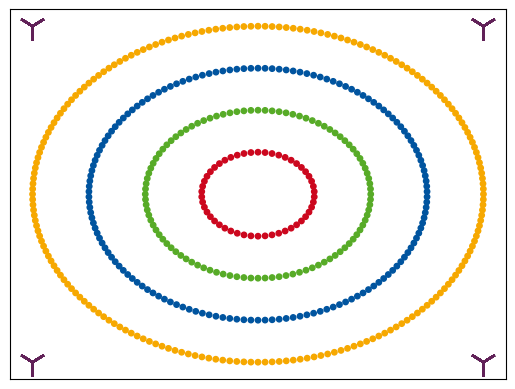

In [159]:
X_noise_at_corner = X_noise.copy()
X_noise_at_corner[-75 * 4 : -75 * 3] = [20, 20]
X_noise_at_corner[-75 * 3 : -75 * 2] = [-20, 20]
X_noise_at_corner[-75 * 2 : -75 * 1] = [20, -20]
X_noise_at_corner[-75 * 1 :] = [-20, -20]

print(X_noise_at_corner.shape, l_noise.shape)

plot_data(X_noise_at_corner, l_noise, save_fig="dartboard_noise_corner", noise_marker_size=400)
print_scores(X_noise_at_corner, l_noise)

(1300, 2) (1300,)


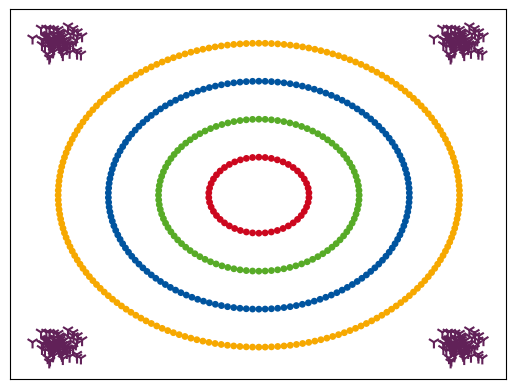

In [160]:
from sklearn.datasets import make_blobs

noise_blob = make_blobs(centers=[[20, 20]], n_samples=75, random_state=0)[0]
noise_blob[0]

X_noise_at_corner = X_noise.copy()
X_noise_at_corner[-75 * 4 : -75 * 3] = make_blobs(centers=[[20, 20]], n_samples=75, random_state=0)[0]
X_noise_at_corner[-75 * 3 : -75 * 2] = make_blobs(centers=[[-20, 20]], n_samples=75, random_state=0)[0]
X_noise_at_corner[-75 * 2 : -75 * 1] = make_blobs(centers=[[20, -20]], n_samples=75, random_state=0)[0]
X_noise_at_corner[-75 * 1 :] = make_blobs(centers=[[-20, -20]], n_samples=75, random_state=0)[0]

print(X_noise_at_corner.shape, l_noise.shape)

plot_data(X_noise_at_corner, l_noise, save_fig="dartboard_noise_corner_blob")
print_scores(X_noise_at_corner, l_noise)

(1300, 2) (1300,)


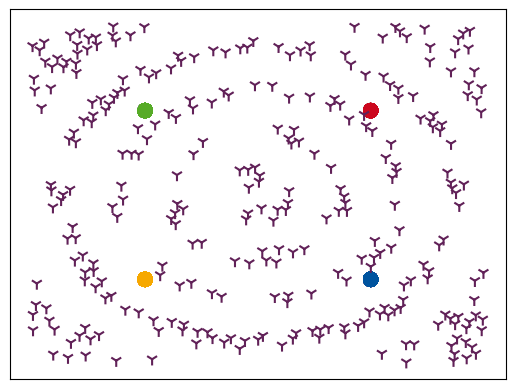

In [161]:
X_at_corner = X_noise.copy()
X_at_corner[:100] = [10, 10]
X_at_corner[100:300] = [-10, 10]
X_at_corner[300:600] = [10, -10]
X_at_corner[600:1000] = [-10, -10]
# X_at_corner[:] = [0,0]

print(X_at_corner.shape, l_noise.shape)

plot_data(X_at_corner, l_noise, save_fig="dartboard_quadrat", cluster_marker_size=100)
print_scores(X_at_corner, l_noise)